# Bottom-Up segmentation

[Документация и ссылки на статьи](http://ctruong.perso.math.cnrs.fr/ruptures-docs/build/html/detection/bottomup.html)

Идея алгоритма довольно проста - мы разбиваем наш временной ряд на множество окон равной длины, а затем соседствующие окна объединяются, если они достаточно похожи с точки зрения некоторых метрик расстояния. 

![](https://www.mdpi.com/jmmp/jmmp-04-00088/article_deploy/html/images/jmmp-04-00088-g008.png)

Поскольку данные изначально могут быть сильно зашумлены, перед использованием алгоритма имеет смысл произвести предобработку, например, сделать тот самый SAX-PAA

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# !pip install ruptures
!ls

0_ts_segmentation-204617-c92971.ipynb
1_SAX_PAA_preprocessing-204617-588297.ipynb
2_Bottom_Up_segmentation-204617-8fb190.ipynb
3_PELT_segmentation-204617-74c5e1.ipynb
data
src
src.zip


In [2]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
# sys.path.append(
#     "../"
# )

import matplotlib.pylab as plt
import ruptures as rpt

from src.utils import display
# creation of data
n, dim = 500, 3  # number of samples, dimension
n_bkps, sigma = 3, 5  # number of change points, noise standart deviation
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

In [4]:
# model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
# algo = rpt.BottomUp(model=model).fit(signal)
# my_bkps = algo.predict(n_bkps=3)

# # show results
# display(signal, bkps, my_bkps, figsize=(10, 6))
# plt.show()

# Пример на наших игрушечных

In [5]:
x1 = np.arange(0, 50, 0.1)
x2 = np.arange(50, 100, 0.1)

location_shift = np.concatenate((
        np.random.normal(loc=0.0, size=len(x1)), 
        np.random.normal(loc=5.0, size=len(x2))))

scale_shift = np.concatenate((
        np.random.normal(loc=0.0, scale=1.0, size=len(x1)), 
        np.random.normal(loc=0.0, scale=4.0, size=len(x2))
    ))

seasonality_shift = np.concatenate((
        np.sin(x1) + np.random.normal(loc=0.0, scale=.2, size=len(x1)), 
        np.sin(x2/2) + np.random.normal(loc=0.0, scale=.2, size=len(x2)))
    )

shifts = [location_shift, scale_shift, seasonality_shift]

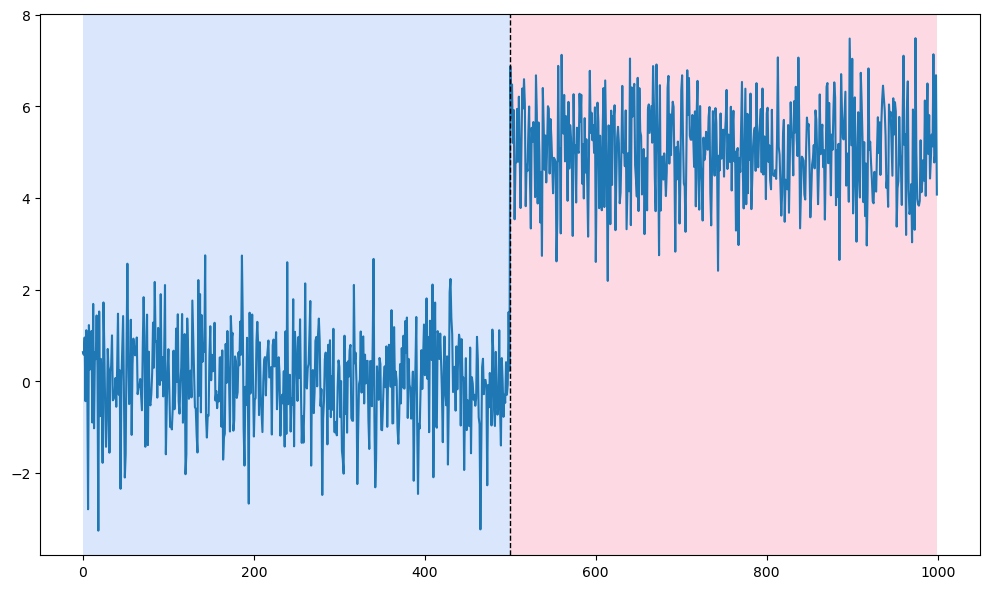

In [6]:
sigma = location_shift.std()
    
algo = rpt.BottomUp(model='l2').fit(location_shift)
bkps = algo.predict(pen = np.log(len(location_shift))*sigma**2)
# show results
display(location_shift, bkps, bkps, figsize=(10, 6))
# plt.savefig('../Presentation/img/location_segment.png')
plt.show()

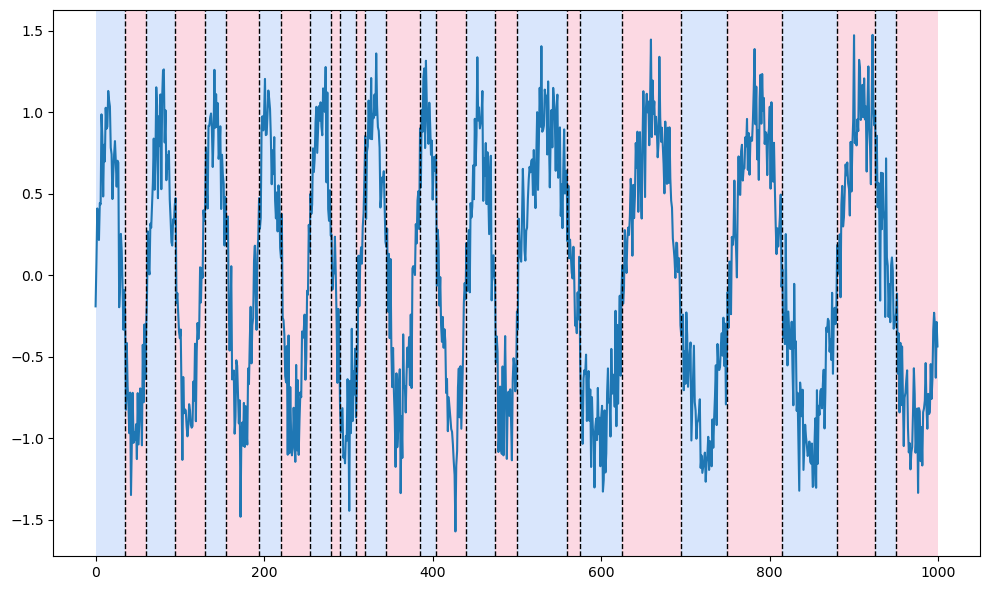

In [7]:
sigma = seasonality_shift.std()
    
algo = rpt.BottomUp(model='l2').fit(seasonality_shift)
bkps = algo.predict(pen = np.log(len(location_shift))*sigma**2)
# show results
display(seasonality_shift, bkps, bkps, figsize=(10, 6))

plt.show()

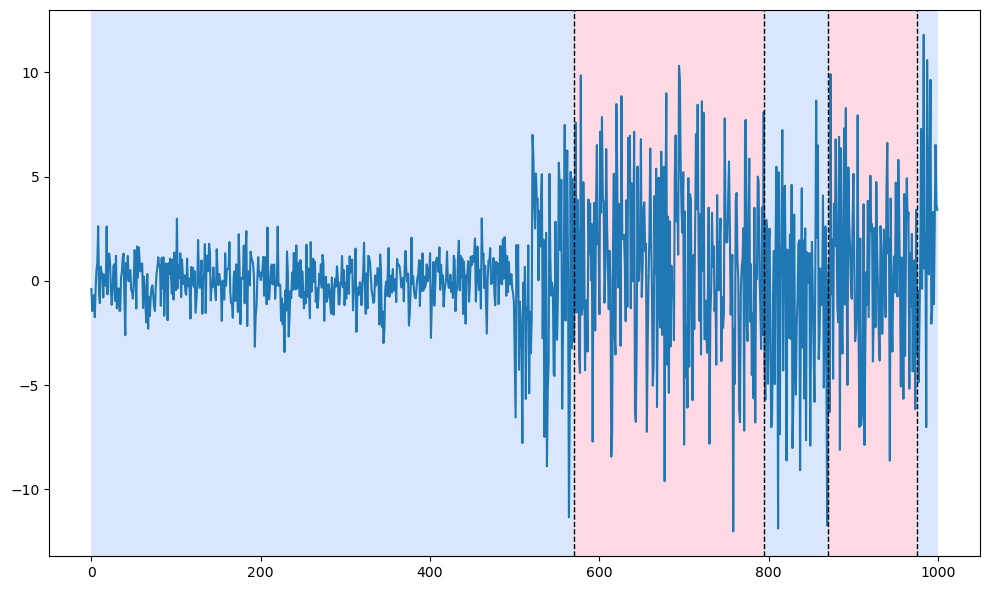

In [17]:
model = "l2" # l2

sigma = scale_shift.std()

algo = rpt.BottomUp(model=model, jump=15).fit(scale_shift)
bkps = algo.predict(pen = np.log(len(scale_shift))*sigma**2)
# show results
display(scale_shift, bkps, bkps, figsize=(10, 6));

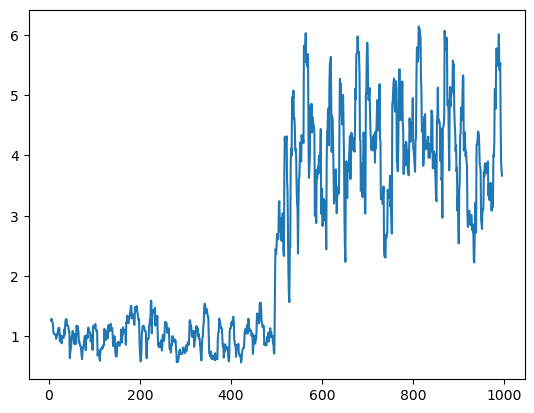

In [18]:
import pandas as pd
plt.plot(pd.Series(scale_shift).rolling(window=10, center=True).std())
plt.show()

# Можно попытаться все-таки исправить ситуацию. 

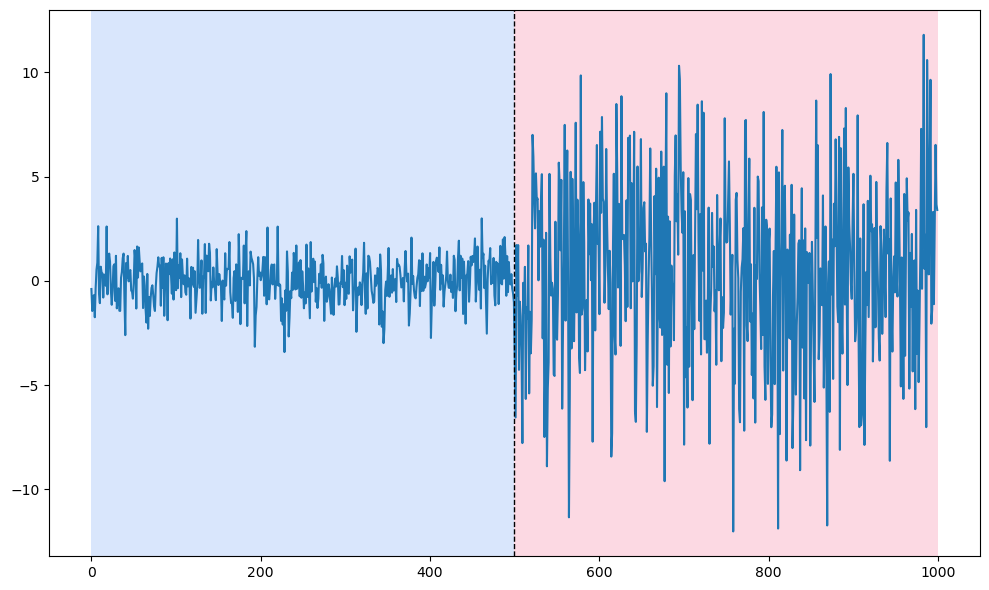

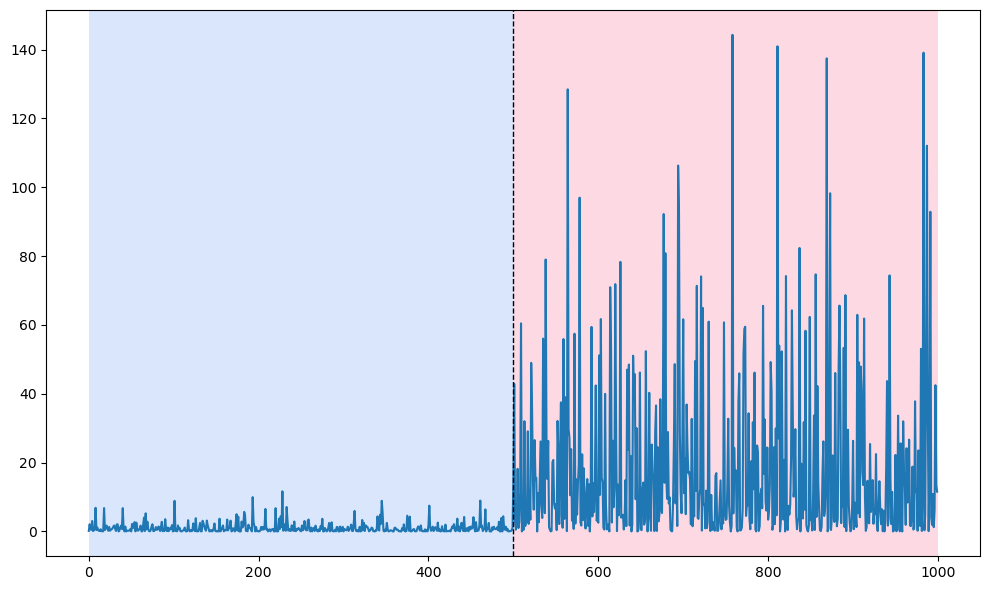

In [20]:
model = "l2"


sigma = scale_shift.std()

algo = rpt.BottomUp(model=model).fit(scale_shift**2) # Возводим в квадрат
bkps = algo.predict(pen = len(scale_shift)*sigma**2)
# show results
display(scale_shift, bkps, bkps, figsize=(10, 6))
# plt.savefig('../Presentation/img/scale_segment.png')
display(scale_shift**2, bkps, bkps, figsize=(10, 6))
plt.show()

# Пример

In [32]:
import pandas as pd
import matplotlib.lines as mlines
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from tslearn.piecewise import SymbolicAggregateApproximation
import ruptures as rpt


def get_bkps(data, model="l2"):
    # model: "l1", "rbf", "linear", "normal", "ar"
    n, dim = data.shape[0], 1  # number of samples, dimension
    sigma = data.std()  # noise standart deviation
    signal, bkps = data, [0]

    # change point detection
    algo = rpt.BottomUp(model=model, jump=12).fit(signal)
    my_bkps = algo.predict(pen=np.log(n)*dim*sigma**2)
    return my_bkps

class StandardScalerDf(StandardScaler):
    """DataFrame Wrapper around StandardScaler"""

    def __init__(self, copy=True, with_mean=True, with_std=True):
        super(StandardScalerDf, self).__init__(copy=copy,
                                                with_mean=with_mean,
                                                with_std=with_std)

    def transform(self, X, y=None):
        z = super(StandardScalerDf, self).transform(X.values)
        return pd.DataFrame(z, index=X.index, columns=X.columns)
    
scaler = StandardScalerDf()

In [33]:
activity_data = pd.read_csv("data/day_data.csv")
activity_data.rename(columns={'ring_met':'met'}, inplace=True)

In [34]:
activity_data.head()

,datetime_local,timezone,met,day
0,2020-01-17 04:00:00,0 days 02:00:00.000000000,1.1,2020-01-17
1,2020-01-17 04:01:00,0 days 02:00:00.000000000,0.9,2020-01-17
2,2020-01-17 04:02:00,0 days 02:00:00.000000000,0.9,2020-01-17
3,2020-01-17 04:03:00,0 days 02:00:00.000000000,0.9,2020-01-17
4,2020-01-17 04:04:00,0 days 02:00:00.000000000,0.9,2020-01-17


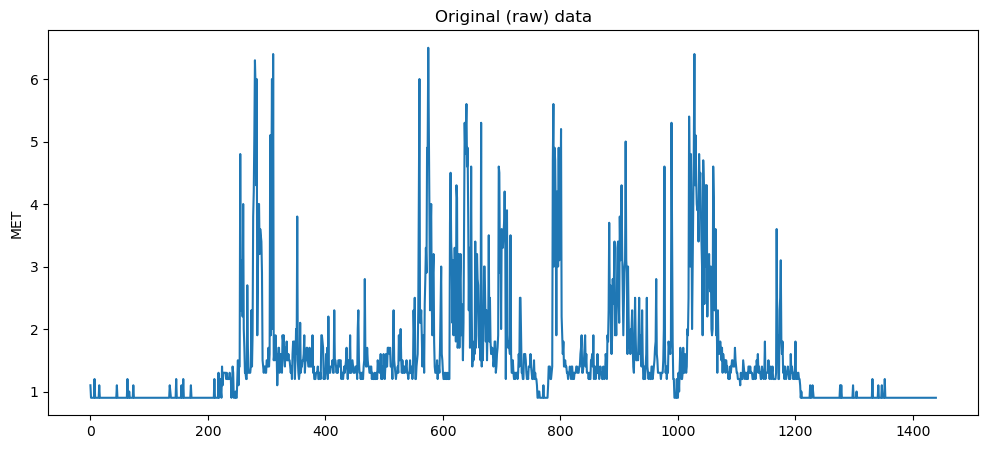

In [35]:
plt.figure(figsize=(12, 5))
plt.plot(activity_data.met, label='Original data')
plt.title("Original (raw) data")
plt.ylabel("MET")
# plt.savefig('../Presentation/img/real.png')
plt.show()

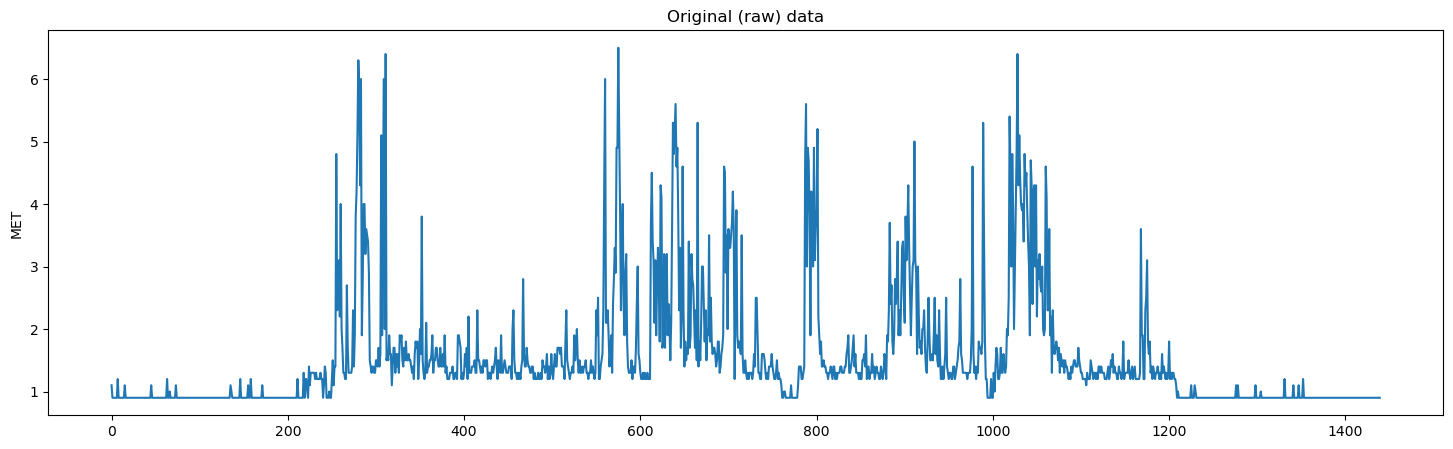

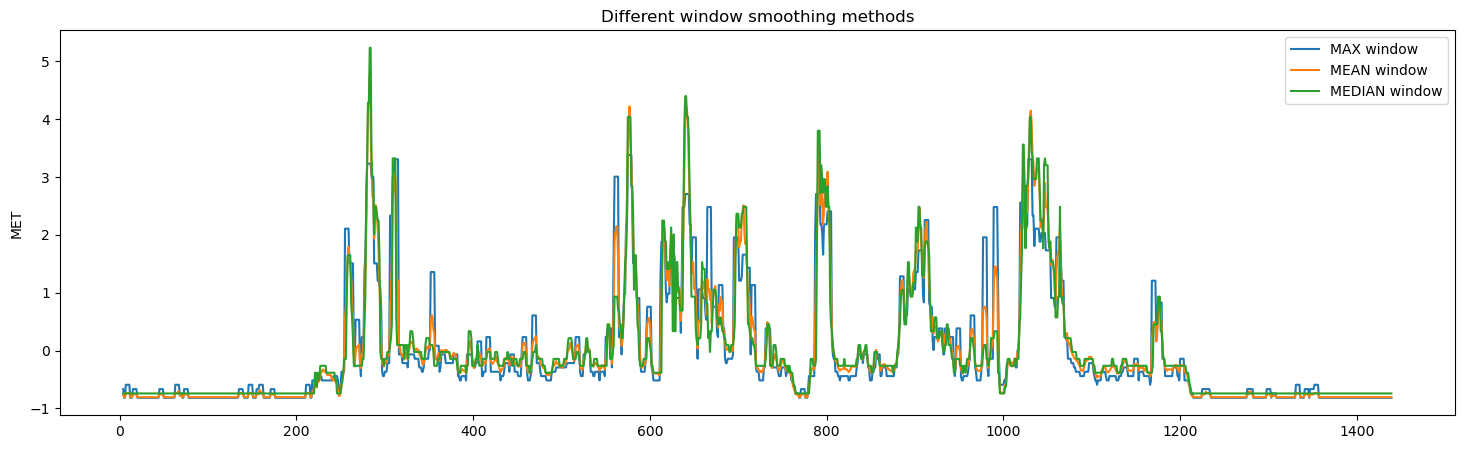

In [36]:
window = 5
plt.figure(figsize=(18, 5))
plt.plot(activity_data.met, label='Original data')
plt.title("Original (raw) data")
plt.ylabel("MET")

data = scaler.fit_transform(pd.DataFrame(activity_data.met.rolling(window=window).max()))
data = data.dropna()

plt.figure(figsize=(18, 5))
plt.plot(data.met, label='MAX window')
data = scaler.fit_transform(pd.DataFrame(activity_data.met.rolling(window=window).mean()))
data = data.dropna()

plt.plot(data.met, label='MEAN window')
data = scaler.fit_transform(pd.DataFrame(activity_data.met.rolling(window=window).median()))
data = data.dropna()

plt.plot(data.met, label='MEDIAN window')
plt.title("Different window smoothing methods")
plt.ylabel("MET")
plt.legend()
plt.show()

In [37]:
data = scaler.fit_transform(pd.DataFrame(activity_data.met.rolling(window=window).median()))
data = data.dropna()

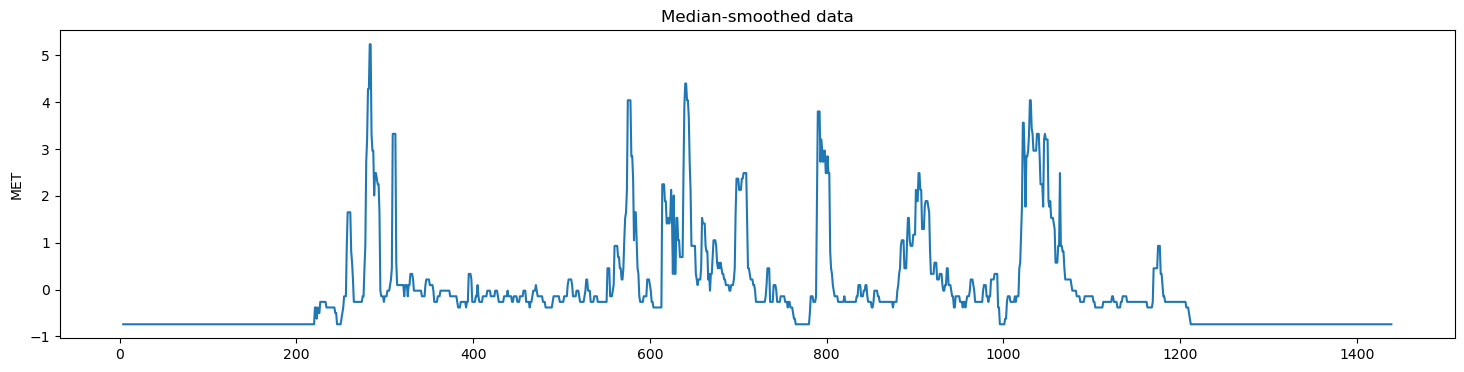

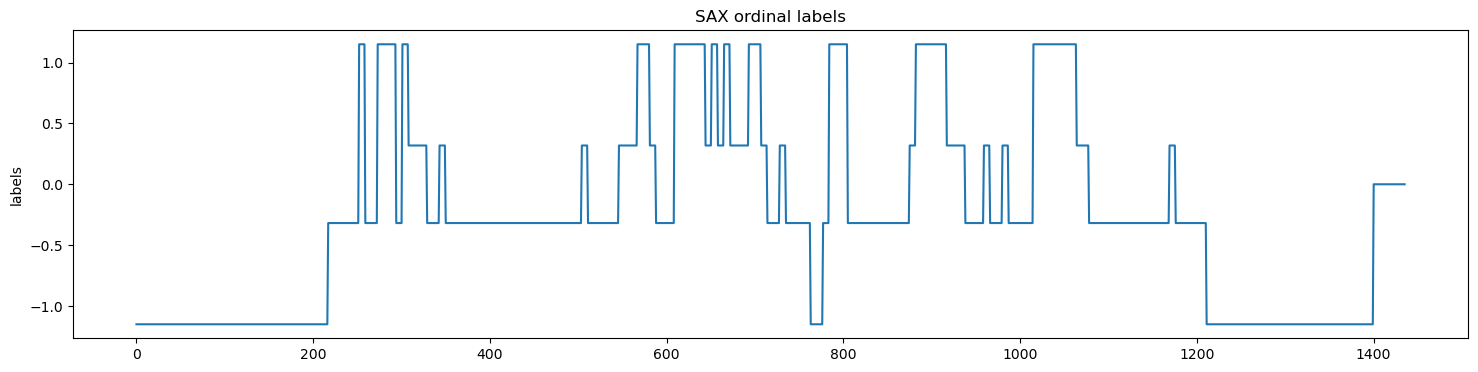

In [38]:
# SAX transform
n_paa_segments = 200
n_sax_symbols = 4
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                    alphabet_size_avg=n_sax_symbols)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform(data.met.values.reshape(1, -1)))

plt.figure(figsize=(18, 4))
plt.plot(data.met)
plt.title('Median-smoothed data')
plt.ylabel("MET")

plt.figure(figsize=(18, 4))
plt.plot(sax_dataset_inv.ravel())
plt.title('SAX ordinal labels')
plt.ylabel("labels");

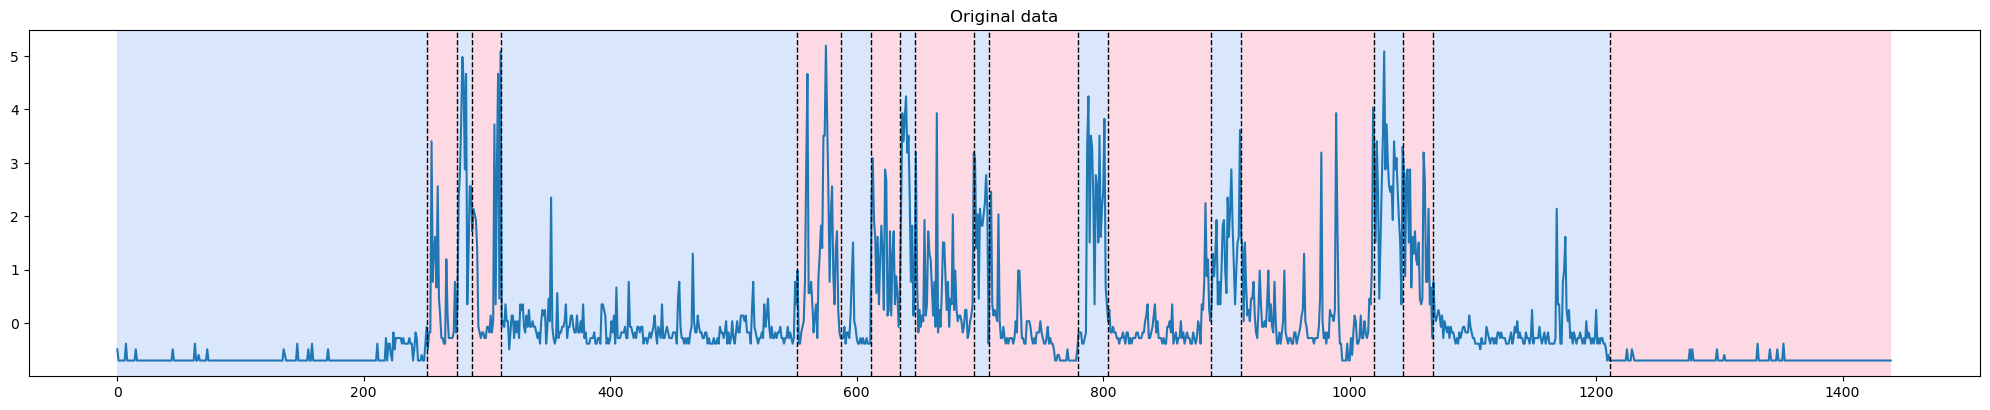

In [39]:
original_data_scaled = scaler.fit_transform(activity_data[['met']])

bkps = get_bkps(original_data_scaled.met.values)
display(original_data_scaled.met, bkps, bkps, figsize=(20, 4), linewidth=0.5)
plt.title("Original data")
plt.show()

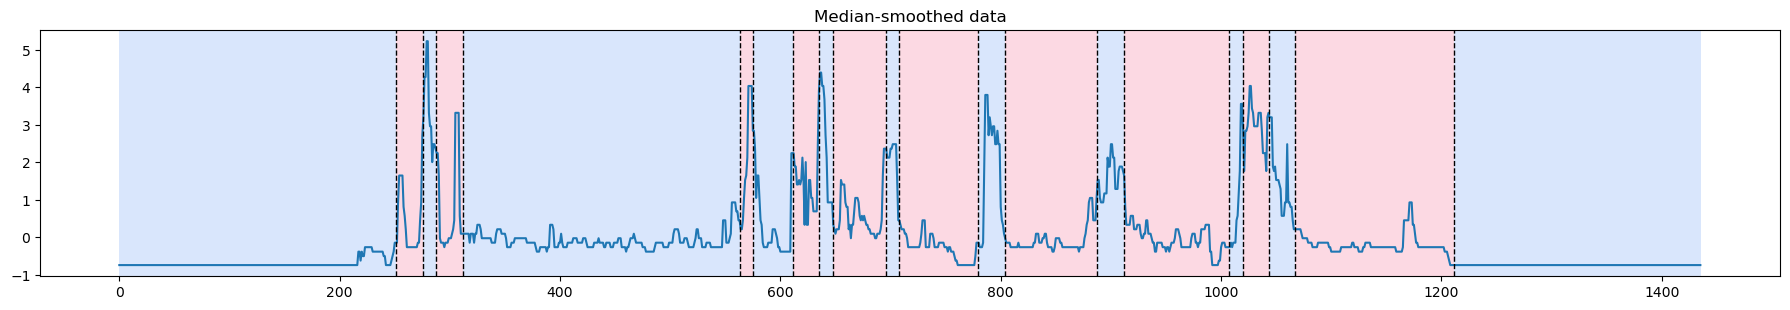

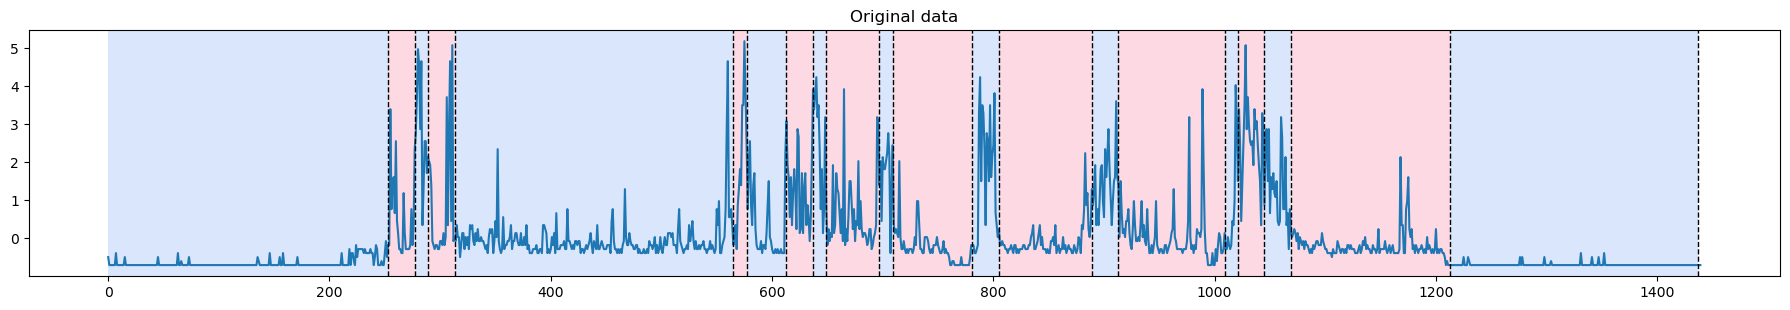

In [40]:
bkps = get_bkps(data.met.values)
display(data.met.values, bkps, bkps, figsize=(18, 3), linewidth=0.5)
plt.title("Median-smoothed data")
plt.show()

display(
    original_data_scaled.met, 
    np.array(bkps)+window/2-1, 
    np.array(bkps)+window/2-1, 
    figsize=(18, 3), 
    linewidth=0.5
)
plt.title("Original data")
plt.show()

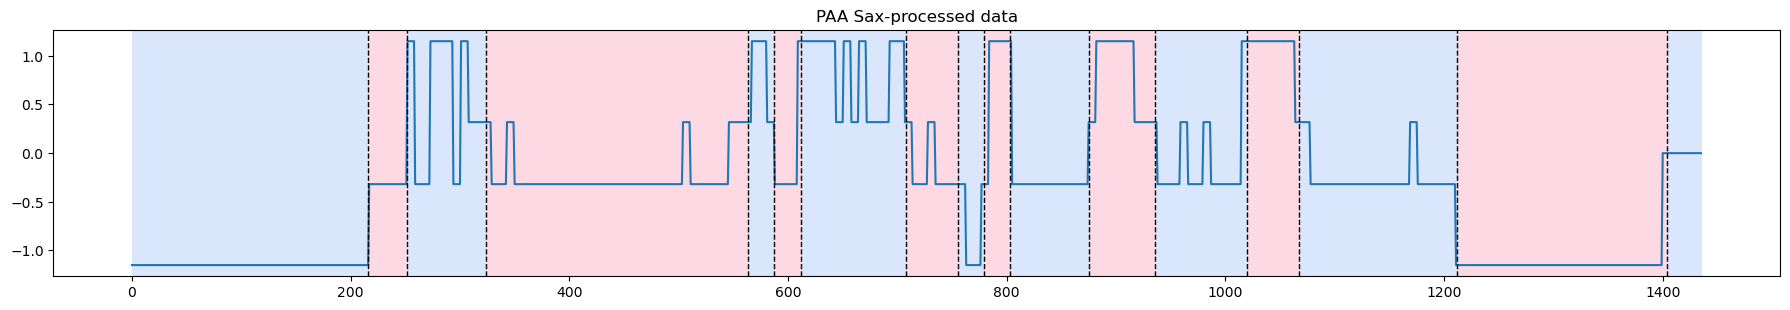

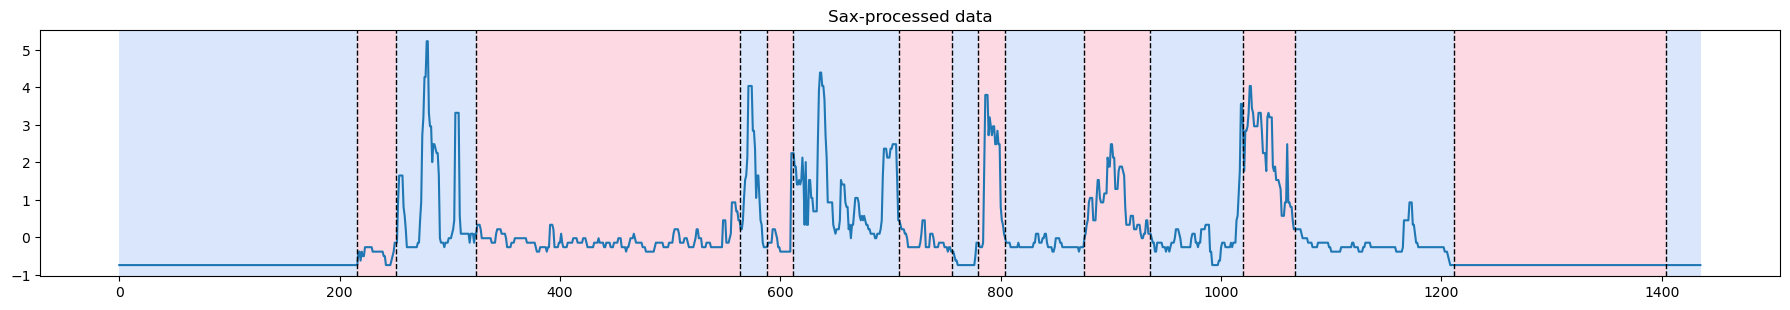

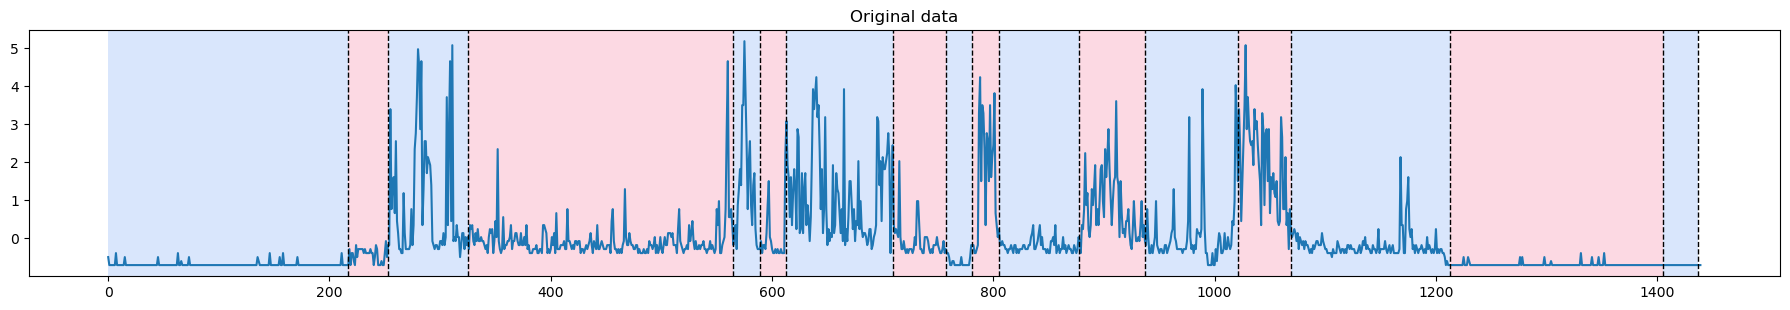

In [41]:
bkps = get_bkps(sax_dataset_inv.ravel())
display(sax_dataset_inv.ravel(), bkps, bkps, figsize=(18, 3), linewidth=0.5)
plt.title("PAA Sax-processed data")
plt.show()

display(data.met.values, bkps, bkps, figsize=(18, 3), linewidth=0.5)
plt.title("Sax-processed data")
plt.show()

display(
    original_data_scaled.met, 
    np.array(bkps)+window/2-1, 
    np.array(bkps)+window/2-1, 
    figsize=(18, 3), 
    linewidth=0.5
)
plt.title("Original data")
plt.show()

### Сможем ли мы улучшить дальнейшую сегментацию этим же методом?